### Import libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Get DataFrame from URL

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [3]:
data = pd.read_html(url, header = 0)

### Get data based on headings

In [4]:
headings = ['Postcode','Borough','Neighborhood']
for tables in data:
    current_headings = tables.columns.values[:4]
    if all(current_headings == headings):
        break

In [5]:
tables.head()

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [6]:
tables['Borough'].unique()

array(['Not assigned', 'North York', 'Downtown Toronto', "Queen's Park",
       'Scarborough', 'East York', 'Etobicoke', 'York', 'East Toronto',
       'West Toronto', 'Central Toronto', 'Mississauga'], dtype=object)

In [7]:
### Drop 'Not assigned' in Borough columns

In [8]:
process_table = tables[tables['Borough']!='Not assigned'].reset_index().drop('index', axis=1)
process_table.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [9]:
process_table['Borough'].unique()

array(['North York', 'Downtown Toronto', "Queen's Park", 'Scarborough',
       'East York', 'Etobicoke', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

### Join the Neighborhood based on similar Postcode with seperated units = ','

In [10]:
df = pd.DataFrame(process_table.groupby(['Postcode','Borough'])['Neighborhood'].apply(','.join)).reset_index()
df.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Change the 'Not assigned' on 'Neighborhood' columns = values in 'Borough' colunmns

In [11]:
df.loc[df['Neighborhood']=='Not assigned','Neighborhood'] = df.loc[df['Neighborhood']=='Not assigned','Borough']

In [12]:
df.shape

(103, 3)

### Use beautiful soup

In [13]:
from bs4 import BeautifulSoup
import requests

In [14]:
page_response = requests.get(url)
page_content = BeautifulSoup(page_response.content,'html.parser')

In [15]:
table = page_content.find('table',{'class':'wikitable sortable'})
rows = table.find_all('tr')
raw_df = pd.DataFrame(columns=['PostalCode', 'Borough', 'Neighborhood'])

In [16]:
for row in rows:
    row_items = row.find_all('td')
    if len(row_items) > 0:
        postcode = row_items[0].text.strip()
        borough = row_items[1].text.strip()
        if borough.lower() != 'not assigned':
            neighborhood = row_items[2].text.strip()
            raw_df = raw_df.append({'PostalCode':postcode, 
                                    'Borough':borough, 
                                    'Neighborhood':neighborhood}, 
                                   ignore_index = True)
raw_df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


## Get coordiantes

### Import Latitude, Longitude DataFrame

In [17]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_acb4ec1c5b4e4d1d93b9537f81b893de = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='fhkEDOCiCI_MFhVncCys4BOz2gbJnlP9PrBDwVAdUqZg',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_acb4ec1c5b4e4d1d93b9537f81b893de.get_object(Bucket='ibm-donotdelete-pr-nwgssxw8mib9fo',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
df_data_0 = pd.read_csv(body)
df_data_0.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merge 2 DataFrame

In [18]:
df_data_0.columns = ['Postcode','Latitude','Longitude']
df = pd.merge(df,df_data_0)
df.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [19]:
df.shape

(103, 5)

In [20]:
list_index = []
for i in range(0,len(df['Borough'])):
    if 'Toronto' in df['Borough'][i]:
        list_index.append(i)
toronto = df.iloc[list_index,:]
toronto = toronto.reset_index()
toronto.drop('index', axis = 1, inplace = True)
toronto.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


### Get credentials

In [21]:
CLIENT_ID = 'IMFRUJ13ERV10OZXAFQBLCMQDTX5L0QV301NCAC5IFMJP2VY' # your Foursquare ID
CLIENT_SECRET = 'SZZMAPVPCOGZE2KVKJSLIN3GQXNCMOHYFUIFHIRFOVK1PFYT' # your Foursquare Secret
VERSION = '20200106' # Foursquare API version
LIMIT = 10

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IMFRUJ13ERV10OZXAFQBLCMQDTX5L0QV301NCAC5IFMJP2VY
CLIENT_SECRET:SZZMAPVPCOGZE2KVKJSLIN3GQXNCMOHYFUIFHIRFOVK1PFYT


### Get location by geocoders

In [22]:
# !pip install geolocator

In [23]:
from geopy.geocoders import Nominatim
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 43.653963, -79.387207.


### Build function getNearbyVenues

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'], latitudes = toronto['Latitude'], longitudes = toronto['Longitude'])

The Beaches
The Danforth West,Riverdale
The Beaches West,India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park,Summerhill East
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Roselawn
Forest Hill North,Forest Hill West
The Annex,North Midtown,Yorkville
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie
Dovercourt Village,Dufferin
Little Portugal,Trinity
Brockton,Exhibition Place,Parkdale Village
High Park,The Junction South
Parkdale,Roncesvalles
Runnymede

In [26]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


In [27]:
toronto_venues.shape

(349, 7)

### Check how many Venues on each Neighborhood

In [28]:
toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide,King,Richmond",10,10,10,10,10,10
Berczy Park,10,10,10,10,10,10
"Brockton,Exhibition Place,Parkdale Village",10,10,10,10,10,10
Business Reply Mail Processing Centre 969 Eastern,10,10,10,10,10,10
"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",10,10,10,10,10,10


In [29]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 119 uniques categories.


### Analyze and Get the frequency of each category on Neighborhood

In [30]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[82]] + list(toronto_onehot.columns[:-1])
fixed_columns.pop(83)
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Bakery,Bank,Bar,Beer Bar,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Café,Candy Store,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Cuban Restaurant,Dance Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Eastern European Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,Historic Site,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Korean Restaurant,Lake,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Museum,Music Venue,Opera House,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pizza Place,Playground,Plaza,Portuguese Restaurant,Pub,Ramen Restaurant,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Skate Park,Skating Rink,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Vegetarian / Vegan Restaurant,Wine Bar
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
toronto_onehot.shape

(349, 118)

In [32]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Bakery,Bank,Bar,Beer Bar,Bookstore,Boutique,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Café,Candy Store,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Comic Shop,Concert Hall,Cosmetics Shop,Creperie,Cuban Restaurant,Dance Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dog Run,Eastern European Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,Historic Site,Hotel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Korean Restaurant,Lake,Liquor Store,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Museum,Music Venue,Opera House,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pizza Place,Playground,Plaza,Portuguese Restaurant,Pub,Ramen Restaurant,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Skate Park,Skating Rink,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Vegetarian / Vegan Restaurant,Wine Bar
0,"Adelaide,King,Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0
1,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0
2,"Brockton,Exhibition Place,Parkdale Village",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",0.1,0.1,0.2,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [33]:
toronto_grouped.shape

(39, 118)

### Print each neighborhood along with the top 5 most common venues

In [34]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,King,Richmond----
          venue  freq
0    Steakhouse   0.2
1  Concert Hall   0.1
2         Plaza   0.1
3     Speakeasy   0.1
4   Opera House   0.1


----Berczy Park----
               venue  freq
0       Concert Hall   0.1
1             Museum   0.1
2     Farmers Market   0.1
3           Beer Bar   0.1
4  French Restaurant   0.1


----Brockton,Exhibition Place,Parkdale Village----
                venue  freq
0         Coffee Shop   0.2
1      Breakfast Spot   0.1
2  Italian Restaurant   0.1
3                 Gym   0.1
4        Climbing Gym   0.1


----Business Reply Mail Processing Centre 969 Eastern----
                  venue  freq
0            Comic Shop   0.1
1         Auto Workshop   0.1
2            Restaurant   0.1
3        Farmers Market   0.1
4  Fast Food Restaurant   0.1


----CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara----
                venue  freq
0      Airport Lounge   0.2
1     Airport Service   0

### Put into DataFrame

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide,King,Richmond",Steakhouse,Hotel,Asian Restaurant,Concert Hall,Plaza
1,Berczy Park,Cocktail Bar,Steakhouse,Concert Hall,Museum,Liquor Store
2,"Brockton,Exhibition Place,Parkdale Village",Coffee Shop,Café,Furniture / Home Store,Breakfast Spot,Pet Store
3,Business Reply Mail Processing Centre 969 Eastern,Skate Park,Auto Workshop,Garden Center,Pizza Place,Burrito Place
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Lounge,Airport Service,Airport,Harbor / Marina,Rental Car Location


In [37]:
neighborhoods_venues_sorted.shape

(39, 6)

### Cluster Neighborhood

Run *k*-means to cluster the neighborhood into 5 clusters.

In [38]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

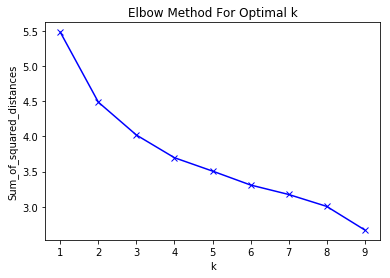

In [39]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# k means determine k
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

# Plot the elbow
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [40]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [41]:
toronto_grouped_clustering.shape

(39, 117)

### Create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood

In [42]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Other Great Outdoors,Trail,Coffee Shop,Pub,Health Food Store
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,1,Greek Restaurant,Ice Cream Shop,Brewery,Fruit & Vegetable Store,Cosmetics Shop
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,1,Park,Sushi Restaurant,Italian Restaurant,Burger Joint,Ice Cream Shop
3,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Coffee Shop,Cheese Shop,Bookstore,Ice Cream Shop,Fish Market
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,Swim School,Bus Line,Dim Sum Restaurant,Park,Wine Bar


In [43]:
toronto_merged.dropna(subset = ['Cluster Labels'], inplace = True)
toronto_merged.shape

(39, 11)

In [44]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

In [45]:
toronto_merged.shape

(39, 11)

In [46]:
!pip install folium

In [47]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [48]:
# Toronto map
toronto_map = folium.Map(location = [latitude,longitude], zoom_start= 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to map
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(toronto_map)
       
toronto_map

### Examine Clusters

#### Cluster 1

In [49]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,Central Toronto,0,Trail,Playground,Gym,Wine Bar,Eastern European Restaurant
10,Downtown Toronto,0,Park,Trail,Playground,Wine Bar,Dog Run


In [50]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,East Toronto,1,Other Great Outdoors,Trail,Coffee Shop,Pub,Health Food Store
1,East Toronto,1,Greek Restaurant,Ice Cream Shop,Brewery,Fruit & Vegetable Store,Cosmetics Shop
2,East Toronto,1,Park,Sushi Restaurant,Italian Restaurant,Burger Joint,Ice Cream Shop
3,East Toronto,1,Coffee Shop,Cheese Shop,Bookstore,Ice Cream Shop,Fish Market
4,Central Toronto,1,Swim School,Bus Line,Dim Sum Restaurant,Park,Wine Bar
5,Central Toronto,1,Park,Gym,Hotel,Sandwich Place,Food & Drink Shop
6,Central Toronto,1,Chinese Restaurant,Sporting Goods Shop,Mexican Restaurant,Dessert Shop,Restaurant
7,Central Toronto,1,Dessert Shop,Italian Restaurant,Sushi Restaurant,Park,Pizza Place
9,Central Toronto,1,Coffee Shop,Sushi Restaurant,Restaurant,Pub,Liquor Store
11,Downtown Toronto,1,Café,General Entertainment,Bakery,Diner,Restaurant


In [51]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
22,Central Toronto,2,Garden,Wine Bar,Farmers Market,College Gym,Comic Shop
